MODELO FINAL DE MACHINE LEARNING

In [ ]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Carga de datos
df = pd.read_excel("accidentes_con_probabilidades.xlsx")

# Eliminamos columnas no informativas
df = df.drop(columns=['IDENTIFICADOR_EMPRESA', 'FECHA', 'HORA'])

# Definimos variable objetivo
X = df.drop(columns=['GRAVEDAD'])
y = df['GRAVEDAD']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identificamos tipo de variables
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categóricas:", categorical_cols)
print("Numéricas:", numeric_cols)

# Definimos los transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Definimos la grilla de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1
)

# Ajuste del modelo
grid.fit(X_train, y_train)

# Evaluación
print("Mejores parámetros encontrados:", grid.best_params_)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Categóricas: ['EMPRESA', 'DEPARTAMENTO', 'MUNICIPIO', 'CENTRO_POBLADO', 'UBICACION', 'SEXO', 'TIPO_IDENTIFICACION', 'VINCULADO_EMPRESA', 'TIPO_VINCULACION', 'GRADO_ESCOLARIDAD', 'SECCION_EMPRESA', 'TIPO_LESION', 'ORIGEN_ACCIDENTE', 'CAUSA_ACCIDENTE', 'MEDIDAS;']
Numéricas: ['ANIO', 'TRIMESTRE', 'COD_DANE', 'EDAD', 'TIEMPO_VINCULACION', 'probabilidad_grave']
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros encontrados: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        95
           1       1.00      0.56      0.71         9

    accuracy                           0.96       104
   macro avg       0.98      0.78      0.85       104
weighted avg       0.96      0.96      0.96       104


Matriz de confusión:
[[95  0]
 [ 4  5]]


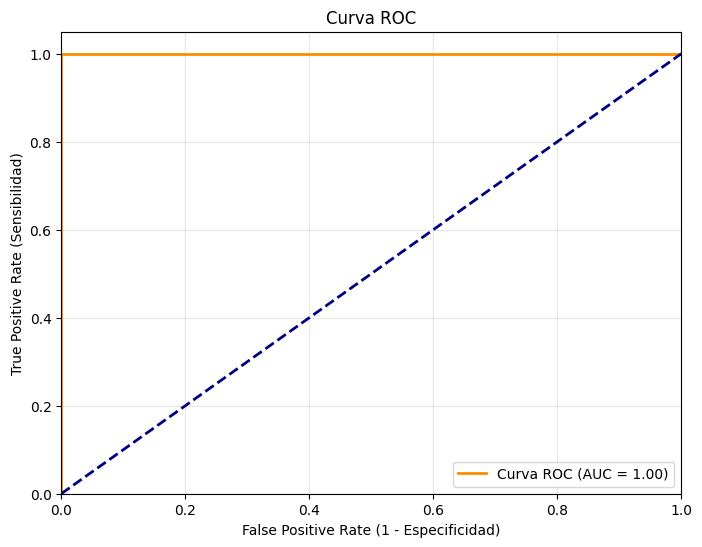

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculamos las probabilidades de predicción
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficamos
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Especificidad)')
plt.ylabel('True Positive Rate (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [8]:
import pandas as pd

# Cargamos el archivo
df = pd.read_excel("accidentes_con_probabilidades.xlsx")

# Revisamos que la columna de probabilidades existe
print(df.columns)

Index(['IDENTIFICADOR_EMPRESA', 'EMPRESA', 'FECHA', 'ANIO', 'TRIMESTRE',
       'HORA', 'COD_DANE', 'DEPARTAMENTO', 'MUNICIPIO', 'CENTRO_POBLADO',
       'UBICACION', 'SEXO', 'EDAD', 'TIPO_IDENTIFICACION', 'VINCULADO_EMPRESA',
       'TIPO_VINCULACION', 'GRADO_ESCOLARIDAD', 'TIEMPO_VINCULACION',
       'SECCION_EMPRESA', 'TIPO_LESION', 'ORIGEN_ACCIDENTE', 'CAUSA_ACCIDENTE',
       'MEDIDAS;', 'GRAVEDAD', 'probabilidad_grave'],
      dtype='object')


In [9]:
# Sumamos las probabilidades
muertes_esperadas = df['probabilidad_grave'].sum()

# Número total de registros
n_total = len(df)

# Promedio de probabilidad de muerte
promedio_probabilidad = df['probabilidad_grave'].mean()

print(f"Número total de accidentes: {n_total}")
print(f"Número esperado de muertes (suma de probabilidades): {muertes_esperadas:.2f}")
print(f"Promedio de probabilidad de muerte por accidente: {promedio_probabilidad:.4f}")

Número total de accidentes: 520
Número esperado de muertes (suma de probabilidades): 13.31
Promedio de probabilidad de muerte por accidente: 0.0256


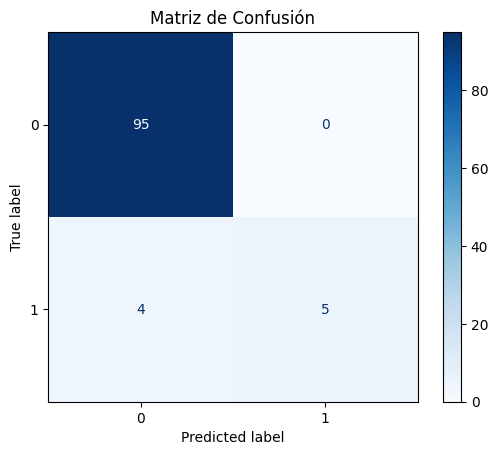

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Suponiendo que y_test son las etiquetas verdaderas y y_pred las predichas por el modelo
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_34068\3178753964.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


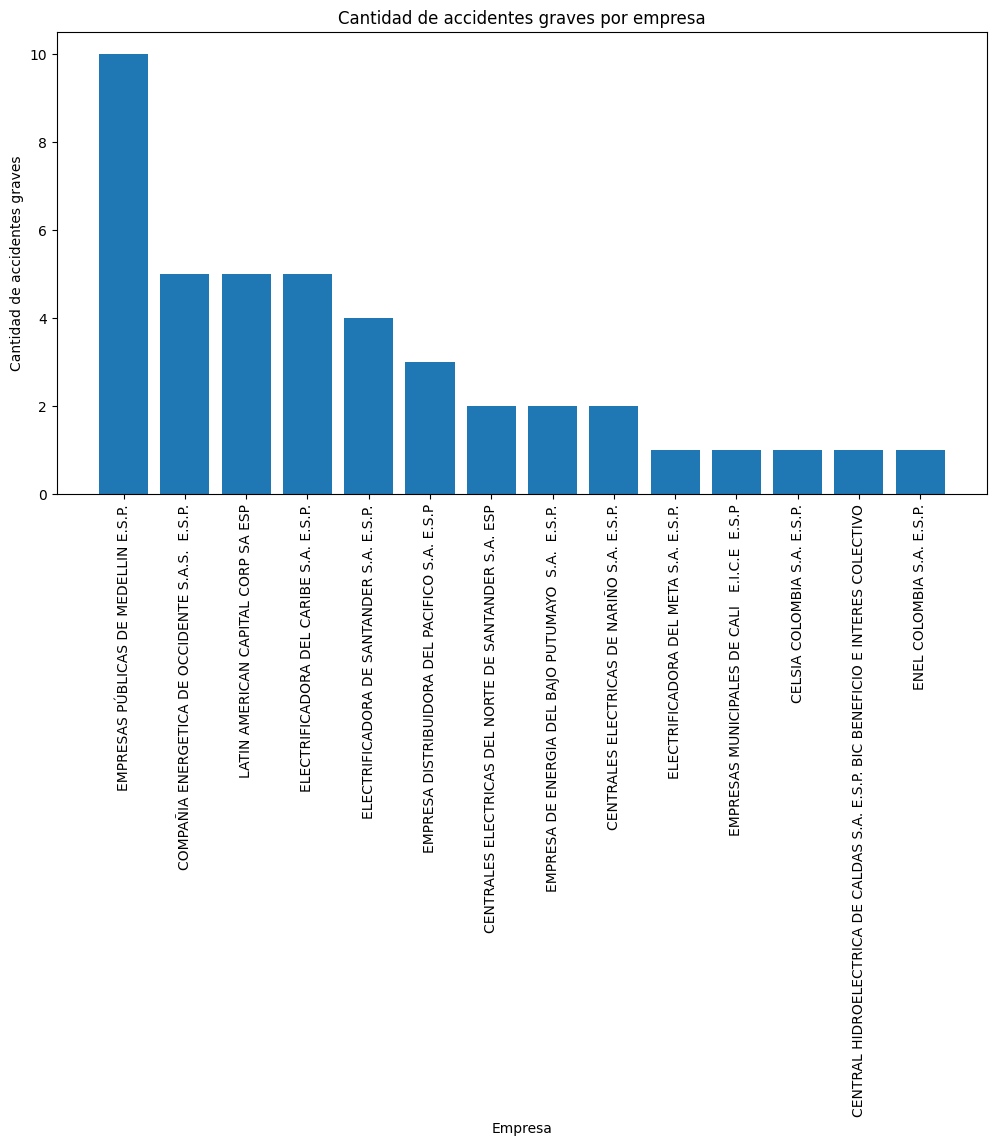

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar solo accidentes graves (muertes)
df_graves = df[df['GRAVEDAD'] == 1]

# Contar accidentes graves por empresa
accidentes_por_empresa = df_graves['EMPRESA'].value_counts().reset_index()
accidentes_por_empresa.columns = ['EMPRESA', 'Accidentes graves']

# Ordenar por cantidad de accidentes graves
accidentes_por_empresa = accidentes_por_empresa.sort_values('Accidentes graves', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(accidentes_por_empresa['EMPRESA'], accidentes_por_empresa['Accidentes graves'])
plt.xlabel('Empresa')
plt.ylabel('Cantidad de accidentes graves')
plt.title('Cantidad de accidentes graves por empresa')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()







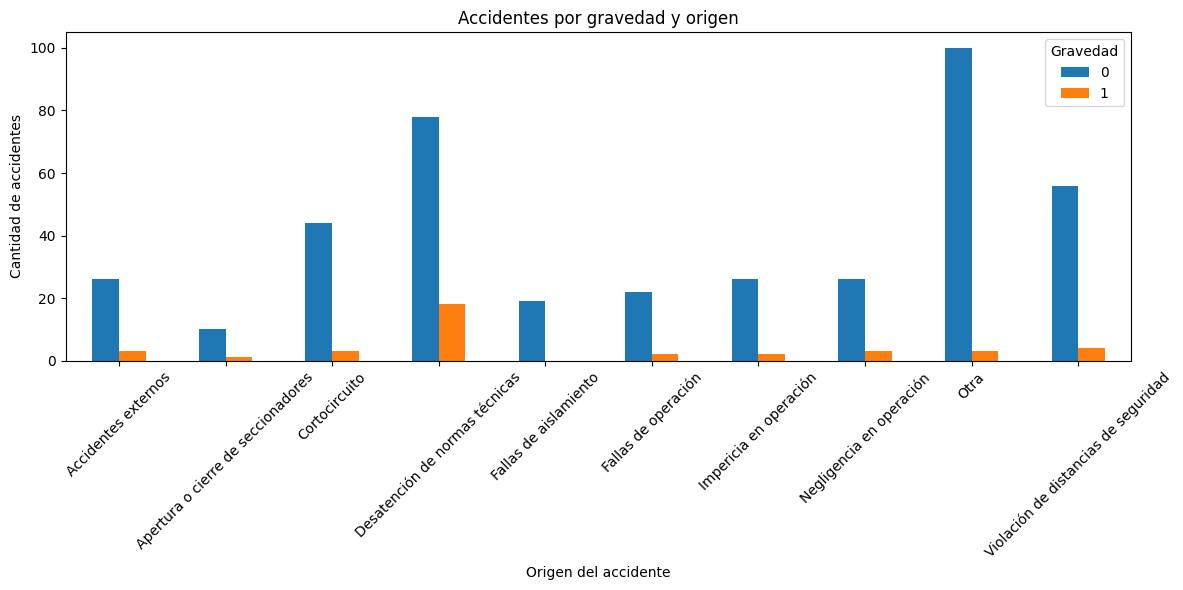

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear tabla de frecuencias cruzadas (contingencia)
tabla = pd.crosstab(df['ORIGEN_ACCIDENTE'], df['GRAVEDAD'])


top_origenes = df['ORIGEN_ACCIDENTE'].value_counts().head(10).index
tabla = pd.crosstab(df[df['ORIGEN_ACCIDENTE'].isin(top_origenes)]['ORIGEN_ACCIDENTE'], df['GRAVEDAD'])

# Hacer gráfico de barras agrupadas
tabla.plot(kind='bar', figsize=(12,6))

plt.xlabel('Origen del accidente')
plt.ylabel('Cantidad de accidentes')
plt.title('Accidentes por gravedad y origen')
plt.xticks(rotation=45)
plt.legend(title='Gravedad')
plt.tight_layout()
plt.show()

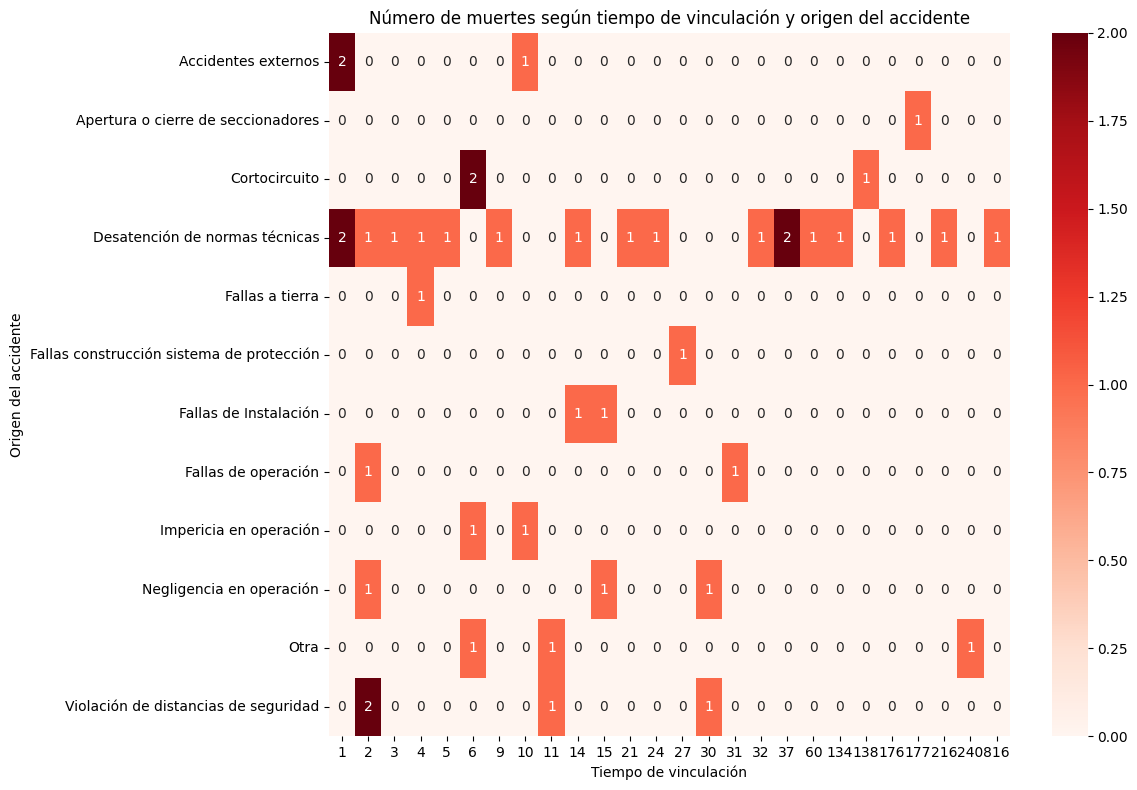

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo muertes
df_muertes = df[df['GRAVEDAD'] == 1]

# Cree una tabla dinámica: filas = ORIGEN, columnas = TIEMPO_VINCULACION, valores = número de muertes
pivot = pd.pivot_table(
    df_muertes,
    index='ORIGEN_ACCIDENTE', 
    columns='TIEMPO_VINCULACION',  # Cambie por el nombre real en su base
    values='GRAVEDAD',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Reds')
plt.title('Número de muertes según tiempo de vinculación y origen del accidente')
plt.xlabel('Tiempo de vinculación')
plt.ylabel('Origen del accidente')
plt.tight_layout()
plt.show()

In [38]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ANIO', 'TRIMESTRE',
                                                   'COD_DANE', 'EDAD',
                                                   'TIEMPO_VINCULACION',
                                                   'probabilidad_grave']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['EMPRESA', 'DEPARTAMENTO',
                                                   'MUNICIPIO',
                                                   'CENTRO_POBLADO',
                                                   'UBICACION', 'SEXO',
                                                   'TIPO_IDENTIFICACION',
                                                   'VINCULADO_EMPRESA',
                                                   'TIPO_VINCULACION',
                                                   'GRADO_ESCOLARIDAD',
                                                   'SECCION_EMPRESA',
                                                   'TIPO_LESION',
                                                   'ORIGEN_ACCIDENTE',
                                                   'CAUSA_ACCIDENTE',
                                                   'MEDIDAS;'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [39]:
# Si la base original incluye la variable objetivo (muertes), elimínela para predecir
X = df.drop(columns=['GRAVEDAD'])  # Cambie 'GRAVEDAD' por el nombre correcto si difiere

# Realizar predicciones
df['PREDICCION_MUERTE'] = pipeline.predict(X)
df.to_excel('base_con_predicciones.xlsx', index=False)
